In [1]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn
import shap
from chemprop.data.utils import get_data, split_data
from matplotlib.patches import Patch
from sklearn import manifold, metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import auc

mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"

In [2]:
repo_path = '../'  # path to the repository
working_dir = '../results'  # where results will be saved

os.makedirs(working_dir, exist_ok=True)

print("Repo path set: {p}".format(p=repo_path))
print("Working directory set: {p}".format(p=working_dir))

Repo path set: ../
Working directory set: ../results


In [3]:
## Drugs obtained from DICTrank database (https://www.sciencedirect.com/science/article/pii/S1359644623002866, 
##                                    https://www.biorxiv.org/content/10.1101/2023.10.15.562398v1, 
##                                    https://www.fda.gov/science-research/bioinformatics-tools/drug-induced-cardiotoxicity-rank-dictrank-dataset
##                                    )

## Load drugs w DICTRANK value and ADMET-AI predictions
admet_ai_data_df = pd.read_csv(os.path.join(repo_path, 'data', 'ADMET-AI_data.csv'), index_col=0)
admet_ai_X_df = pd.read_csv(os.path.join(repo_path, 'data', 'ADMET-AI_Xvals.csv'), index_col=0)
admet_ai_y_df = pd.read_csv(os.path.join(repo_path, 'data', 'ADMET-AI_yvals.csv'), index_col=0)

## Load drugs w DICTRANK value and SwissADME predictions
swiss_data_df = pd.read_csv(os.path.join(repo_path, 'data', 'SwissADME_data.csv'), index_col=0)
swiss_X_df = pd.read_csv(os.path.join(repo_path, 'data', 'SwissADME_Xvals.csv'), index_col=0)
swiss_y_df = pd.read_csv(os.path.join(repo_path, 'data', 'SwissADME_yvals.csv'), index_col=0)



In [4]:
dictrank_data_sets = {'ADMET-AI': {'data': admet_ai_data_df,
                                   'X': admet_ai_X_df,
                                   'y': admet_ai_y_df,
                                   },
                      'SwissADME': {'data': swiss_data_df,
                                    'X': swiss_X_df,
                                    'y': swiss_y_df,
                                    },
                      }


In [5]:
## Load data through chemprop for scaffold split generation

adxdata = get_data(os.path.join(repo_path, 'data', 'ADMET-AI_data.csv'),
                   smiles_columns=["Standardized_SMILES"],
                   target_columns=["DICTrank"]
                   )

555it [00:00, 91194.81it/s]
100%|████████████████████████████████████████| 555/555 [00:00<00:00, 682.71it/s]


In [6]:
## Split data by chemical scaffold using chemprop 

num_folds = 10
scaf_splits = {}

for seed in range(num_folds):
    # Split data
    train, val, test = split_data(
        data=adxdata,
        split_type='scaffold_balanced',
        num_folds=num_folds,
        seed=seed,
        sizes=(0.80, 0.0, 0.20)
    )
    if seed not in scaf_splits:
        scaf_splits[seed] = {}

    for split, name in [(train, "train"), (val, "val"), (test, "test")]:
        smiles = []
        dranks = []
        indices = []
        for i, s in enumerate(split.smiles()):
            smiles.append(s[0])
            dranks.append(split.targets()[i][0])
            indices.append(dictrank_data_sets['ADMET-AI']['data'][
                               dictrank_data_sets['ADMET-AI']['data']['Standardized_SMILES'] == s[0]].index[0])
        split_df = pd.DataFrame({
            "data_index": indices,
            "Standardized_SMILES": smiles,
            "DICTrank": dranks
        })
        if name not in scaf_splits[seed]:
            scaf_splits[seed][name] = []
        scaf_splits[seed][name] = split_df


100%|███████████████████████████████████████| 555/555 [00:00<00:00, 9145.60it/s]


In [7]:
xxx = '''
HIA_Hou	Human Intestinal Absorption
Bioavailability_Ma	Oral Bioavailability
Solubility_AqSolDB	Aqueous Solubility
Lipophilicity_AstraZeneca	Lipophilicity
HydrationFreeEnergy_FreeSolv	Hydration Free Energy
Caco2_Wang	Cell Effective Permeability
PAMPA_NCATS	PAMPA Permeability
Pgp_Broccatelli	P-glycoprotein Inhibition
BBB_Martins	Blood-Brain Barrier Penetration
PPBR_AZ	Plasma Protein Binding Rate
VDss_Lombardo	Volume of Distribution at Steady State
Half_Life_Obach	Half Life
Clearance_Hepatocyte_AZ	Drug Clearance (Hepatocyte)
Clearance_Microsome_AZ	Drug Clearance (Microsome)
CYP1A2_Veith	CYP1A2 Inhibition
CYP2C19_Veith	CYP2C19 Inhibition
CYP2C9_Substrate_CarbonMangels	CYP2C9 Substrate
CYP2C9_Veith	CYP2C9 Inhibition
CYP2D6_Substrate_CarbonMangels	CYP2D6 Substrate
CYP2D6_Veith	CYP2D6 Inhibition
CYP3A4_Substrate_CarbonMangels	CYP3A4 Substrate
CYP3A4_Veith	CYP3A4 Inhibition
hERG	hERG Blocking
ClinTox	Clinical Toxicity
AMES	Mutagenicity
DILI	Drug Induced Liver Injury
Carcinogens_Lagunin	Carcinogenicity
LD50_Zhu	Acute Toxicity LD50
Skin_Reaction	Skin Reaction
NR-AR	Androgen Receptor (Full Length)
NR-AR-LBD	Androgen Receptor (Ligand Binding Domain)
NR-AhR	Aryl Hydrocarbon Receptor
NR-Aromatase	Aromatase
NR-ER	Estrogen Receptor (Full Length)
NR-ER-LBD	Estrogen Receptor (Ligand Binding Domain)
NR-PPAR-gamma	Peroxisome Proliferator-Activated Receptor Gamma
SR-ARE	Nrf2-Antioxidant Responsive Element
SR-ATAD5	ATPase Family AAA Domain-Containing Protein 5 (ATAD5)
SR-HSE	Heat Shock Factor Response Element
SR-MMP	Mitochondrial Membrane Potential
SR-p53	Tumor Protein p53
'''.split('\n')[1:-1]
feat_name_dict = {}
for l in xxx:
    y = l.split('\t')
    feat_name_dict[y[0]] = y[1].replace('/', '\n')

admet_ai_feats = [
    'AMES', 'BBB_Martins', 'Bioavailability_Ma', 'CYP1A2_Veith',
    'CYP2C19_Veith', 'CYP2C9_Substrate_CarbonMangels', 'CYP2C9_Veith',
    'CYP2D6_Substrate_CarbonMangels', 'CYP2D6_Veith',
    'CYP3A4_Substrate_CarbonMangels', 'CYP3A4_Veith', 'Carcinogens_Lagunin',
    'ClinTox', 'DILI', 'HIA_Hou', 'NR-AR-LBD', 'NR-AR', 'NR-AhR',
    'NR-Aromatase', 'NR-ER-LBD', 'NR-ER', 'NR-PPAR-gamma', 'PAMPA_NCATS',
    'Pgp_Broccatelli', 'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53',
    'Skin_Reaction', 'hERG', 'Caco2_Wang', 'Clearance_Hepatocyte_AZ',
    'Clearance_Microsome_AZ', 'Half_Life_Obach',
    'HydrationFreeEnergy_FreeSolv', 'LD50_Zhu', 'Lipophilicity_AstraZeneca',
    'PPBR_AZ', 'Solubility_AqSolDB', 'VDss_Lombardo'
]

swiss_feats = [
    'MW', '#Heavy atoms', '#Aromatic heavy atoms', 'Fraction Csp3',
    '#Rotatable bonds', '#H-bond acceptors', '#H-bond donors', 'MR', 'TPSA',
    'iLOGP', 'XLOGP3', 'WLOGP', 'MLOGP', 'Silicos-IT Log P',
    'Consensus Log P', 'ESOL Log S', 'ESOL Solubility (mg/ml)',
    'ESOL Solubility (mol/l)', 'Ali Log S', 'Ali Solubility (mg/ml)',
    'Ali Solubility (mol/l)', 'Silicos-IT LogSw',
    'Silicos-IT Solubility (mg/ml)', 'Silicos-IT Solubility (mol/l)',
    'GI absorption', 'BBB permeant', 'Pgp substrate', 'CYP1A2 inhibitor',
    'CYP2C19 inhibitor', 'CYP2C9 inhibitor', 'CYP2D6 inhibitor',
    'CYP3A4 inhibitor', 'log Kp (cm/s)', 'Lipinski #violations',
    'Ghose #violations', 'Veber #violations', 'Egan #violations',
    'Muegge #violations', 'Bioavailability Score', 'PAINS #alerts',
    'Brenk #alerts', 'Leadlikeness #violations', 'Synthetic Accessibility'
]

In [8]:
dictrank_colors = {'none': '#99d594',
                   'most': '#df65b0',
                   }

feat_color_dict = {'SwissADME': '#fe9929',
                   'ADMET-AI': '#4eb3d3',
                   }

admet_class_color_dict = {
    'Absorption': '#ffffb3',
    'Distribution': '#80b1d3',
    'Metabolism': '#bebada',
    'Excretion': '#fccde5',
    'Toxicity': '#fb8072',
}

admet_class_dict = {
    'Mutagenicity': 'Toxicity',
    'Blood-Brain Barrier Penetration': 'Distribution',
    'Oral Bioavailability': 'Absorption',
    'CYP1A2 Inhibition': 'Metabolism',
    'CYP2C19 Inhibition': 'Metabolism',
    'CYP2C9 Substrate': 'Metabolism',
    'CYP2C9 Inhibition': 'Metabolism',
    'CYP2D6 Substrate': 'Metabolism',
    'CYP2D6 Inhibition': 'Metabolism',
    'CYP3A4 Substrate': 'Metabolism',
    'CYP3A4 Inhibition': 'Metabolism',
    'Carcinogenicity': 'Toxicity',
    'Clinical Toxicity': 'Toxicity',
    'Drug Induced Liver Injury': 'Toxicity',
    'Human Intestinal Absorption': 'Absorption',
    'Androgen Receptor (Ligand Binding Domain)': 'Toxicity',
    'Androgen Receptor (Full Length)': 'Toxicity',
    'Aryl Hydrocarbon Receptor': 'Toxicity',
    'Aromatase': 'Toxicity',
    'Estrogen Receptor (Ligand Binding Domain)': 'Toxicity',
    'Estrogen Receptor (Full Length)': 'Toxicity',
    'Peroxisome Proliferator-Activated Receptor Gamma': 'Toxicity',
    'PAMPA Permeability': 'Absorption',
    'P-glycoprotein Inhibition': 'Absorption',
    'Nrf2-Antioxidant Responsive Element': 'Toxicity',
    'ATPase Family AAA Domain-Containing Protein 5 (ATAD5)': 'Toxicity',
    'Heat Shock Factor Response Element': 'Toxicity',
    'Mitochondrial Membrane Potential': 'Toxicity',
    'Tumor Protein p53': 'Toxicity',
    'Skin Reaction': 'Toxicity',
    'hERG Blocking': 'Toxicity',
    'Cell Effective Permeability': 'Absorption',
    'Drug Clearance (Hepatocyte)': 'Excretion',
    'Drug Clearance (Microsome)': 'Excretion',
    'Half Life': 'Excretion',
    'Hydration Free Energy': 'Absorption',
    'Acute Toxicity LD50': 'Toxicity',
    'Lipophilicity': 'Absorption',
    'Plasma Protein Binding Rate': 'Distribution',
    'Aqueous Solubility': 'Absorption',
    'Volume of Distribution at Steady State': 'Distribution'
}

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 555 samples in 0.001s...
[t-SNE] Computed neighbors for 555 samples in 0.365s...
[t-SNE] Computed conditional probabilities for sample 555 / 555
[t-SNE] Mean sigma: 18.928235
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.061516
[t-SNE] KL divergence after 2000 iterations: 0.711645


/var/folders/bf/_w85crz95sv363n4qwp3krzc0000gn/T/ipykernel_17433/2394786461.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=20)
/var/folders/bf/_w85crz95sv363n4qwp3krzc0000gn/T/ipykernel_17433/2394786461.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=20)


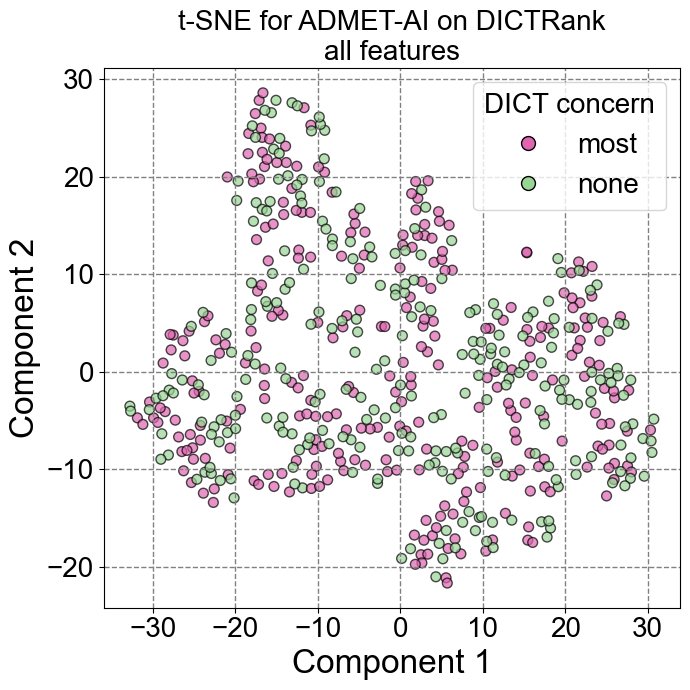

In [9]:
## Plot T-SNE all features


t_sne = manifold.TSNE(
    verbose=True,
    n_components=2, learning_rate=100,
    init='pca', perplexity=30, n_iter=2000,
    random_state=0,
)

data_df = dictrank_data_sets['ADMET-AI']['data']
Xx = dictrank_data_sets['ADMET-AI']['X']

S_t_sne = t_sne.fit_transform(Xx)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

cols = np.empty(len(Xx.index), dtype=object)

for c in dictrank_data_sets['ADMET-AI']['y']['DICT _ Concern'].unique():
    ii = np.argwhere(np.asarray(dictrank_data_sets['ADMET-AI']['y']) == c)
    if c == 'most':
        c = 'most'
    else:
        c = 'none'
    ax.plot([], [], marker='o', color=dictrank_colors[c], markersize=10,
            linestyle='', label=c, markeredgecolor='k', markeredgewidth=1)

    cols[ii] = dictrank_colors[c]

# ax.set_aspect('equal', adjustable='box')
x, y = S_t_sne.T
divergence = t_sne.kl_divergence_

ax.scatter(x, y, c=list(filter(None, cols)), s=50, alpha=0.7, marker='o', edgecolors='k',
           linewidth=1)
ax.set_title('t-SNE for ADMET-AI on DICTRank\nall features', fontsize=20)
leg = ax.legend(loc='best', fontsize=20, title='DICT concern')
#     ax.set_xlim([-0.05, 1.05])
#     ax.set_ylim([-0.05, 1.05])
ax.set_ylabel('Component 2', fontsize=24)
ax.set_xlabel('Component 1', fontsize=24)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=20)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=20)
ax.grid(axis='both', which='major', color='grey', linestyle='--', linewidth=1)
plt.setp(leg.get_title(), fontsize=20)
plt.tight_layout()
plt.savefig(os.path.join(working_dir, 'xGB_scaffold_split_ADMET-AI_all_feats_T-SNE.pdf'))
plt.show()

/var/folders/bf/_w85crz95sv363n4qwp3krzc0000gn/T/ipykernel_17433/3527751865.py:126: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=24)
/var/folders/bf/_w85crz95sv363n4qwp3krzc0000gn/T/ipykernel_17433/3527751865.py:127: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=24)


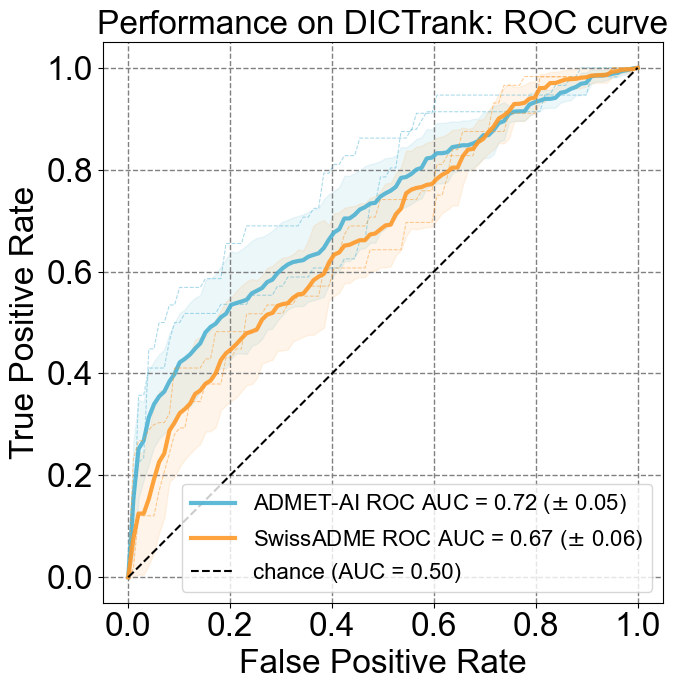

/var/folders/bf/_w85crz95sv363n4qwp3krzc0000gn/T/ipykernel_17433/3527751865.py:163: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=24)
/var/folders/bf/_w85crz95sv363n4qwp3krzc0000gn/T/ipykernel_17433/3527751865.py:164: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=24)


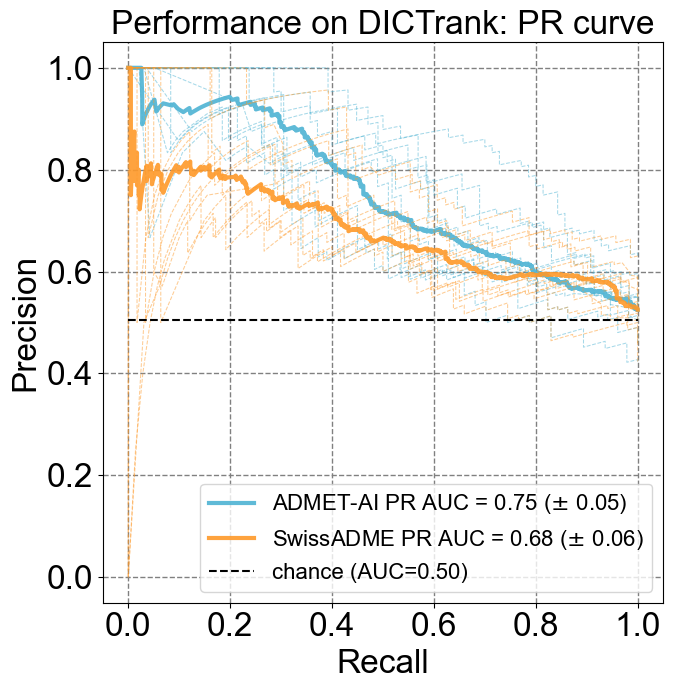

In [10]:
## xGB scaffold split

# Initialize SHAP feature imp dictionaries and dataframes
all_feat_shap_df = pd.DataFrame(index=admet_ai_feats, columns=list(dictrank_data_sets))
shap_vals = dict()
shap_val_dfs = {}

# Intialize ROC & PR performance np arrays
tprs = {}
roc_aucs = {}
pr_aucs = {}
precisions = {}
recalls = {}
y_real = {}
y_prob = {}

# Loop through feature types (ADMET-AI, SwissADME)

for f in dictrank_data_sets:

    # Intialize data, X and y values for feature set
    data_df = dictrank_data_sets[f]['data']
    Xx = dictrank_data_sets[f]['X']

    y = dictrank_data_sets[f]['y']['DICT _ Concern']
    yy = []
    for yx in y:
        if yx == 'no':
            yy.append(0)
        else:
            yy.append(1)
    yy = np.asarray(yy)
    Xf = Xx

    # Intialize performance and feature imp. measurements for feature type
    tprs[f] = []
    roc_aucs[f] = []
    pr_aucs[f] = []
    precisions[f] = []
    recalls[f] = []
    y_real[f] = []
    y_prob[f] = []
    mean_fpr = np.linspace(0, 1, 100)
    shapdf = pd.DataFrame()

    # Loop through 10 rounds of cross validation
    for i in scaf_splits:
        # Get chemical scaffold based train and test split for each round of CV

        train_index = list(scaf_splits[i]['train']['data_index'].values)
        test_index = list(scaf_splits[i]['test']['data_index'].values)

        X_train = Xf.iloc[train_index]
        y_train = yy[train_index]

        X_test = Xf.iloc[test_index]
        y_test = yy[test_index]

        # Initialize XGB classifier for each round of CV
        xgb = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1,
                                         max_depth=12, random_state=0)

        # Training XGB
        xgb.fit(X_train, y_train)

        # Getting predictions from XGB
        probs = xgb.predict_proba(X_test)
        preds = probs[:, 1]

        # Measuring performance (ROC and PR curves)
        fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
        precision, recall, threshold = metrics.precision_recall_curve(y_test, preds)
        roc_auc = metrics.auc(fpr, tpr)
        pr_auc = metrics.auc(recall, precision)

        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs[f].append(interp_tpr)
        roc_aucs[f].append(roc_auc)

        recalls[f].append(recall)
        precisions[f].append(precision)
        pr_aucs[f].append(pr_auc)
        y_real[f].append(y_test)
        y_prob[f].append(preds)

        # Feature improtances (SHAP)

        explainer = shap.TreeExplainer(xgb)
        shap_values = explainer.shap_values(X_train).mean(axis=0)
        sdf = pd.DataFrame(data=[shap_values],
                           columns=[str(x) for x in Xf.columns])
        shapdf = pd.concat([shapdf, sdf], ignore_index=True)

    shapdf = shapdf[list(shapdf.mean().sort_values(ascending=False).index)]
    shap_val_dfs[f] = shapdf
    shap_vals[f] = [(k, shapdf.mean().sort_values(ascending=False).index[k], x) for k, x in
                    enumerate(shapdf.mean().sort_values(ascending=False))]

# Plot ROC curve
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
ax.set_aspect('equal', adjustable='box')
for f in tprs:
    for i, tpr in enumerate(tprs):
        ax.plot(mean_fpr, tprs[f][i], color=feat_color_dict[f],
                lw=0.75, alpha=0.5, linestyle='--')
    mean_tpr = np.mean(tprs[f], axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(roc_aucs[f])
    ax.plot(mean_fpr, mean_tpr, color=feat_color_dict[f],
            label=r'{f} ROC AUC = %0.2f ($\pm$ %0.2f)'.format(f=f) % (mean_auc, std_auc),
            lw=3, alpha=0.9)

    std_tpr = np.std(tprs[f], axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color=feat_color_dict[f], alpha=0.1,
                    )
ax.set_title('Performance on DICTrank: ROC curve', fontsize=24)
ax.plot([0, 1], [0, 1], 'k--', label='chance (AUC = 0.50)')
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_ylabel('True Positive Rate', fontsize=24)
ax.set_xlabel('False Positive Rate', fontsize=24)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=24)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=24)
ax.grid(axis='both', which='major', color='grey', linestyle='--', linewidth=1)
ax.legend(loc='lower right', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(working_dir, 'xGB_scaffold_split_ROC.pdf'))
plt.show()

# Plot PR curve
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
ax.set_aspect('equal', adjustable='box')
for f in precisions:
    yr = []
    yp = []
    for j, prec in enumerate(precisions[f]):
        ax.plot(recalls[f][j], precisions[f][j], color=feat_color_dict[f],
                lw=0.75, alpha=0.5, linestyle='--')
        yr.append(y_real[f][j])
        yp.append(y_prob[f][j])

    yr = np.concatenate(yr)
    yp = np.concatenate(yp)

    pr, rec, _ = metrics.precision_recall_curve(yr, yp)

    mean_auc = metrics.average_precision_score(yr, yp)
    std_auc = np.std(pr_aucs[f])

    ax.plot(rec, pr, color=feat_color_dict[f],
            label=r'{f} PR AUC = %0.2f ($\pm$ %0.2f)'.format(f=f) % (mean_auc, std_auc),
            lw=3, alpha=0.9)

ax.set_title('Performance on DICTrank: PR curve', fontsize=24)
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_ylabel('Precision', fontsize=24)
ax.set_xlabel('Recall', fontsize=24)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=24)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=24)
# plot the precision-recall curves
no_skill = len(y_test[y_test == 1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], 'k--',
         label='chance (AUC={f})'.format(f='%0.2f' % metrics.auc([0, 1], [no_skill, no_skill]))
         )
ax.grid(axis='both', which='major', color='grey', linestyle='--', linewidth=1)
ax.legend(loc='lower right', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(working_dir, 'xGB_scaffold_split_PR.pdf'))
plt.show()


/var/folders/bf/_w85crz95sv363n4qwp3krzc0000gn/T/ipykernel_17433/930641471.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=16)


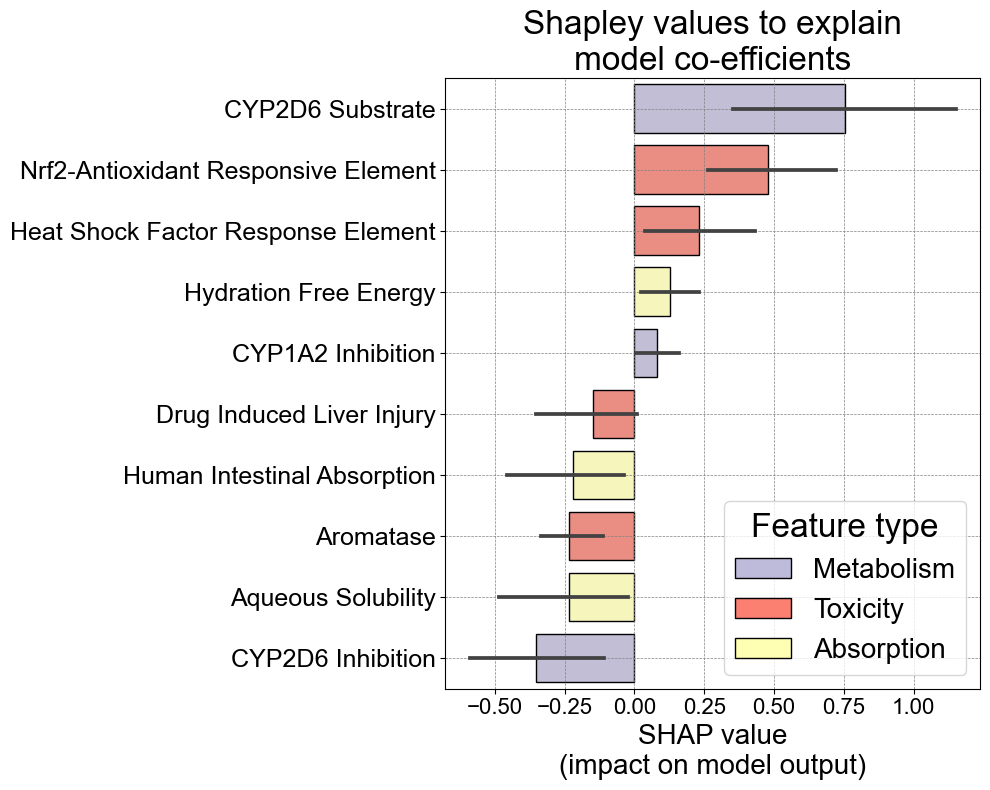

In [11]:
## Plot SHAP value feature importance for ADMET-AI
cpal = []
fidf = shap_val_dfs['ADMET-AI']
fidf = fidf[list(fidf.columns[:5]) + list(fidf.columns[-5:])]

admet_classes = []
for ft in fidf.columns:
    ac = admet_class_dict[ft]
    c = admet_class_color_dict[ac]
    admet_classes.append(ac)
    cpal.append(c)

admet_classes = list(set(admet_classes))

#Create a bar plot of the feature importances
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
fidf = shap_val_dfs['ADMET-AI']
fidf = fidf[list(fidf.columns[:5]) + list(fidf.columns[-5:])]

fidf.to_csv(os.path.join(working_dir, 'ADMET-AI_xGB_shap_vals.csv'.format(f=f)))

seaborn.barplot(fidf, ax=ax, orient="h", palette=cpal, linewidth=1, edgecolor='k', )
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=16)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=18)
ax.grid(axis='both', which='major', color='grey', linestyle='--', linewidth=0.5)
ax.set_xlabel('SHAP value\n(impact on model output)', fontsize=20)
ax.set_title('Shapley values to explain\nmodel co-efficients', fontsize=24)
handles = [
    Patch(facecolor=color, label=label, edgecolor='k')
    for label, color in zip(admet_classes, [admet_class_color_dict[cc] for cc in admet_classes])
]
leg = ax.legend(handles=handles, loc='lower right', fontsize=20, title='Feature type')
plt.setp(leg.get_title(), fontsize=24)
plt.tight_layout()
plt.savefig(os.path.join(working_dir, 'xGB_scaffold_split_SHAP_vals.pdf'))
plt.show()



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 555 samples in 0.002s...
[t-SNE] Computed neighbors for 555 samples in 0.014s...
[t-SNE] Computed conditional probabilities for sample 555 / 555
[t-SNE] Mean sigma: 0.036237
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.465866
[t-SNE] KL divergence after 2000 iterations: 0.446428


/var/folders/bf/_w85crz95sv363n4qwp3krzc0000gn/T/ipykernel_17433/3159317811.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=20)
/var/folders/bf/_w85crz95sv363n4qwp3krzc0000gn/T/ipykernel_17433/3159317811.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=20)


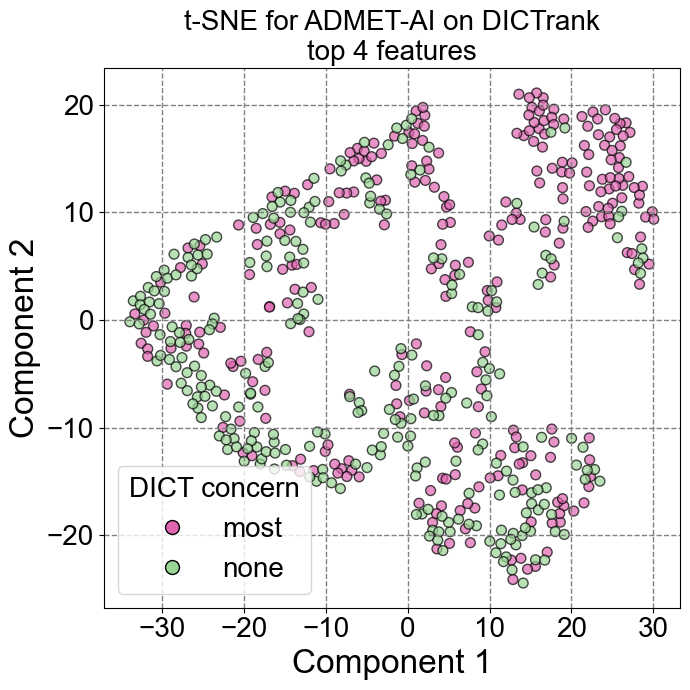

In [12]:
## T-SNE with xGB selected features
sel_feats = ['CYP2D6 Substrate',
             'Nrf2-Antioxidant Responsive Element',
             'Aromatase',
             'CYP2D6 Inhibition'
             ]

t_sne = manifold.TSNE(
    verbose=True,
    n_components=2,
    learning_rate=100,
    init='pca',
    perplexity=30,
    n_iter=2000,
    random_state=0,
)

data_df = dictrank_data_sets['ADMET-AI']['data']
Xx = dictrank_data_sets['ADMET-AI']['X']
yy = dictrank_data_sets['ADMET-AI']['y']['DICT _ Concern']

S_t_sne = t_sne.fit_transform(Xx[sel_feats])

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

cols = np.empty(len(Xx.index), dtype=object)

for c in yy.unique():
    ii = np.argwhere(np.asarray(yy) == c)
    if c == 'most':
        c = 'most'
    else:
        c = 'none'
    ax.plot([], [], marker='o', color=dictrank_colors[c], markersize=10,
            linestyle='', label=c, markeredgecolor='k', markeredgewidth=1)

    cols[ii] = dictrank_colors[c]

x, y = S_t_sne.T
divergence = t_sne.kl_divergence_

ax.scatter(x, y, c=list(filter(None, cols)), s=50, alpha=0.7, marker='o', edgecolors='k',
           linewidth=1)
ax.set_title('t-SNE for ADMET-AI on DICTrank\ntop 4 features', fontsize=20)
leg = ax.legend(loc='best', fontsize=20, title='DICT concern')

ax.set_ylabel('Component 2', fontsize=24)
ax.set_xlabel('Component 1', fontsize=24)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=20)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=20)
ax.grid(axis='both', which='major', color='grey', linestyle='--', linewidth=1)
plt.setp(leg.get_title(), fontsize=20)
plt.tight_layout()
plt.savefig(os.path.join(working_dir, 'xGB_scaffold_split_ADMET-AI_top4_feat_T-SNE.pdf'))
plt.show()

In [13]:
# Load dataframes of drugs with ATC labels to identify therapeutic indication

no_DICT_concern_drugs_df = pd.read_csv(os.path.join(repo_path, 'data', 'allnoDICTdrugs_DICTRank-ADMET-AI_training.csv'))
most_DICT_concern_drugs_df = pd.read_csv(
    os.path.join(repo_path, 'data', 'allhighestDICTdrugs_DICTRank-ADMET-AI_training.csv'))
high_DICT_concern_wdrawn_drugs_df = pd.read_csv(
    os.path.join(repo_path, 'data', 'allwithdrawnDICTdrugs_DICTRank-ADMET-AI_training.csv'))


In [14]:
# Define parameters for radar plots

property_ids = [
    "CYP2D6 Substrate",
    "CYP2D6 Inhibition",
    "Nrf2-Antioxidant Responsive Element",
    "Aromatase",
]
property_ids = [f"{property_id}" for property_id in property_ids]
property_names = [
    "CYP2D6\nSubstrate",
    "CYP2D6\nInhibition",
    "Nrf2-Antioxidant\nResponsive\nElement",
    "Aromatase",
]

dictrank_colors2 = {
    'none': '#99d594',
    'most': '#df65b0',
    'withdrawn': 'red'
}

In [15]:
## Function to plot radar plot

def plot_radar_list_drugs(df, drugs, colors, tox_label):
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    for j, d in enumerate(drugs):
        plt.plot([], [], label=d[0].upper() + d[1:], color=colors[j], linewidth=4,
                 )
        dfi = df[df['name'] == d]
        values = []
        for f in property_ids:
            values.append(dfi[f].values[0])

        # Calculate the angles of the plot (angles start at pi / 2 and go counter-clockwise)
        angles = (
                (np.linspace(0, 2 * np.pi, len(values), endpoint=False) + np.pi / 2)
                % (2 * np.pi)
        ).tolist()

        # Complete the loop
        values += values[:1]
        angles += angles[:1]

        ax.plot(angles, values, color=colors[j], linewidth=4 )

        # Set y limits
        ax.set_ylim(0, 1)

        # Labels for radial lines
        yticks = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
        yticklabels = [str(ytick) for ytick in yticks]
        ax.set_yticks(yticks)
        ax.set_yticklabels(yticklabels, fontsize=12)
        ax.set_rlabel_position(335)

        # Labels for categories
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(property_names, fontsize=18)

        # Adjust xticklabels so they don't overlap the plot
        for i, (label, property_name) in enumerate(
                zip(ax.get_xticklabels(), property_names)
        ):
            if i in [1, 4]:
                label.set_verticalalignment("bottom")
            elif i in [2, 3]:
                label.set_verticalalignment("top")

    # Make the plot square
    ax.set_aspect("equal", "box")
    plt.legend(bbox_to_anchor=(1.25, 1.1), fontsize=14)
    ax.set_title('{l}'.format(l=tox_label), fontsize=22, weight='bold')
    plt.tight_layout()

    return fig


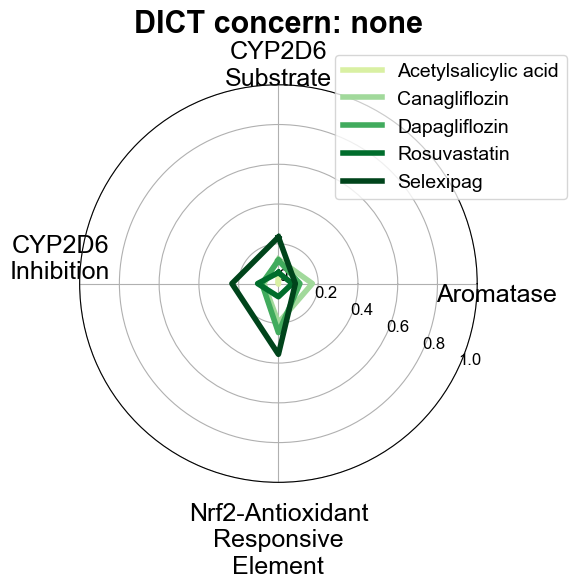

In [16]:
# Plot radar plot for selected no DICT concern drugs

no_DICT_concern_drugs_list = ['Acetylsalicylic acid', 'Canagliflozin', 'Dapagliflozin', 'Rosuvastatin', 'Selexipag']
no_DICT_concern_drugs_colors = ['#d9f0a3', '#a1d99b', '#41ab5d', '#006d2c', '#00441b']

fig = plot_radar_list_drugs(
    df=no_DICT_concern_drugs_df,
    drugs=no_DICT_concern_drugs_list,
    colors=no_DICT_concern_drugs_colors,
    tox_label='DICT concern: none'
)

fig.savefig(os.path.join(working_dir, 'no_DICT_concern_drugs_radar_plot.pdf'))



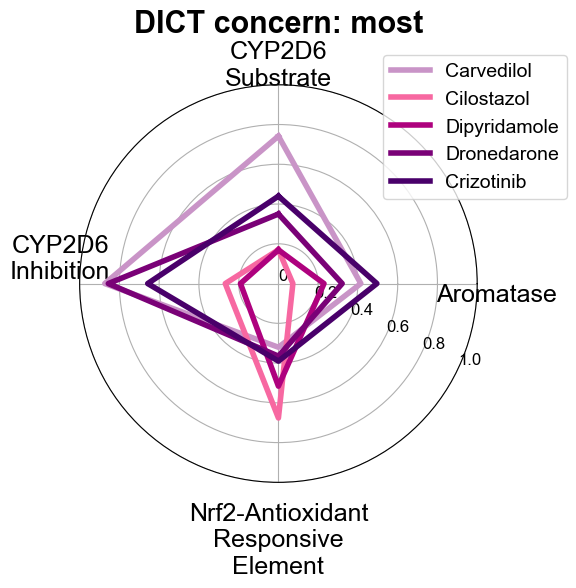

In [17]:
# Plot radar plot for selected most DICT concern drugs

most_DICT_concern_drugs_list = ['Carvedilol', 'Cilostazol', 'Dipyridamole', 'Dronedarone', 'Crizotinib']
most_DICT_concern_drugs_colors = ['#c994c7', '#f768a1', '#ae017e', '#7a0177', '#49006a']

fig = plot_radar_list_drugs(
    df=most_DICT_concern_drugs_df,
    drugs=most_DICT_concern_drugs_list,
    colors=most_DICT_concern_drugs_colors,
    tox_label='DICT concern: most'
)

fig.savefig(os.path.join(working_dir, 'most_DICT_concern_drugs_radar_plot.pdf'))



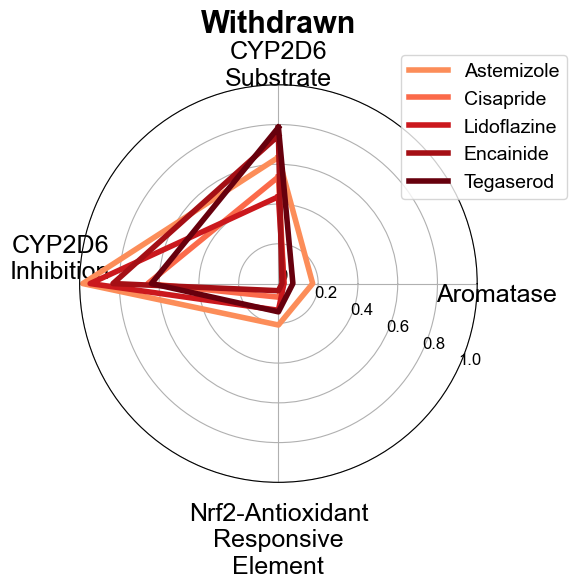

In [18]:
# Plot radar plot for selected high DICT concern; withdrawn drugs

high_DICT_concern_wdrawn_drugs_list = ['Astemizole', 'Cisapride', 'Lidoflazine', 'Encainide', 'Tegaserod']
high_DICT_concern_wdrawn_drugs_colors = ['#fc8d59', '#fb6a4a', '#cb181d', '#a50f15', '#67000d']

fig = plot_radar_list_drugs(
    df=high_DICT_concern_wdrawn_drugs_df,
    drugs=high_DICT_concern_wdrawn_drugs_list,
    colors=high_DICT_concern_wdrawn_drugs_colors,
    tox_label='Withdrawn'
)

fig.savefig(os.path.join(working_dir, 'high_DICT_concern_wdrawn_drugs_radar_plot.pdf'))
